In [14]:
from glob import glob
import sys, time, os, asyncio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy.time import Time, TimeDelta
from scipy.interpolate import UnivariateSpline

from lsst_efd_client import EfdClient, resample, merge_packed_time_series, rendezvous_dataframes
from lsst.ts.idl.enums import MTM1M3

from scipy.signal import find_peaks
from scipy.interpolate import interp1d

from lsst.ts.ofc import BendModeToForce, OFCData

In [15]:
events_frame=pd.read_csv("/home/p/pferguso/u/projects/m1m3/hp_oscillations_during_slew/data/230622_combined_events.csv")

In [16]:
client = EfdClient('usdf_efd')

In [19]:
i_num=58
t_start=Time(events_frame["times"][i_num]-3, format="unix")
t_end=Time(events_frame["times"][i_num]+2, format="unix")


In [20]:
cols=[f"primaryCylinderFollowingError{i}" for i in np.arange(156)]

In [21]:
test_dat=await client.select_time_series( "lsst.sal.MTM1M3.forceActuatorData", \
                                      cols,  t_start, t_end)

In [22]:
FATABLE_INDEX = 0
FATABLE_ID = 1
FATABLE_XPOSITION = 2
FATABLE_YPOSITION = 3
FATABLE_ZPOSITION = 4
FATABLE_TYPE = 5
FATABLE_SUBNET = 6
FATABLE_ADDRESS = 7
FATABLE_ORIENTATION = 8
FATABLE_XINDEX = 9
FATABLE_YINDEX = 10
FATABLE_ZINDEX = 11
FATABLE_SINDEX = 12

from FATABLE import FATABLE as fatable

In [23]:
positions_frame=pd.DataFrame({"id":np.arange(156)})
positions_frame["x"]= [fatable[i][2] for i in np.arange(156)]
positions_frame["y"]= [fatable[i][3] for i in np.arange(156)]
positions_frame["z"]= [fatable[i][4] for i in np.arange(156)]

In [24]:
(test_dat.index[j]-test_dat.index[0]).total_seconds()

NameError: name 'j' is not defined

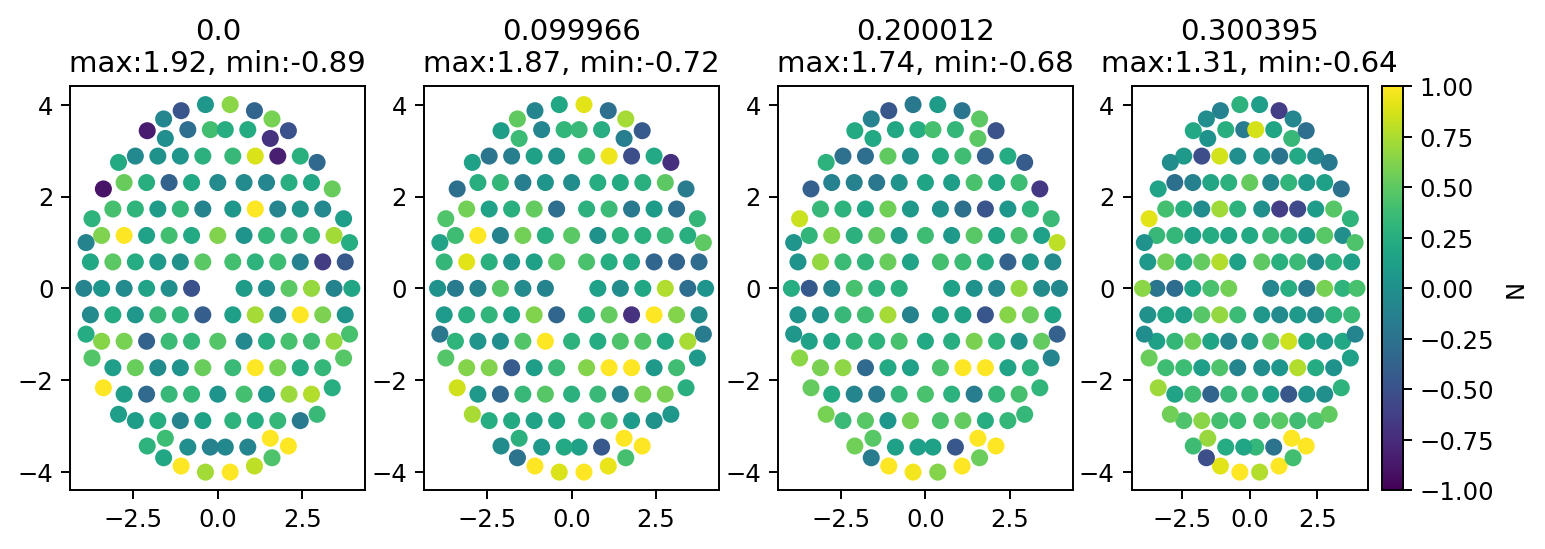

In [26]:
fig, axs=plt.subplots(1,4,dpi=175, figsize=(10,3))
for i,j in enumerate([0,5,10,15]):
    ax=axs[i]
    force0=test_dat.iloc[j,:].values
    ax.set_title(f"{(test_dat.index[j]-test_dat.index[0]).total_seconds()}\nmax:{force0.max():0.2f}, min:{force0.min():0.2f}")
    
    _=ax.scatter(positions_frame["x"], positions_frame["y"], c=force0, vmin=-1, vmax=1)
plt.colorbar(_, label="N")

In [27]:
ofc_data = OFCData("lsst")
bmc=BendModeToForce( "M1M3",ofc_data )

In [43]:
time=(test_dat.index-test_dat.index[0]).total_seconds().values

In [45]:
col_names=[f"mode_{i}" for i in np.arange(20)]


""


In [91]:
from scipy.interpolate import LinearNDInterpolator

In [88]:
m1m3_modes=np.loadtxt("/home/p/pferguso/u/repos/sitcom/ts_lsst_aos_phosim/data/M1M3/M1M3_1um_156_grid.DAT")

In [92]:
LinearNDInterpolator?

Init signature: LinearNDInterpolator(points, values, fill_value=nan, rescale=False)
Docstring:     
LinearNDInterpolator(points, values, fill_value=np.nan, rescale=False)

Piecewise linear interpolant in N > 1 dimensions.

.. versionadded:: 0.9

Methods
-------
__call__

Parameters
----------
points : ndarray of floats, shape (npoints, ndims); or Delaunay
    Data point coordinates, or a precomputed Delaunay triangulation.
values : ndarray of float or complex, shape (npoints, ...)
    Data values.
fill_value : float, optional
    Value used to fill in for requested points outside of the
    convex hull of the input points.  If not provided, then
    the default is ``nan``.
rescale : bool, optional
    Rescale points to unit cube before performing interpolation.
    This is useful if some of the input dimensions have
    incommensurable units and differ by many orders of magnitude.

Notes
-----
The interpolant is constructed by triangulating the input data
with Qhull [1]_, and on each t

In [117]:
from tqdm import tqdm

In [119]:
points=np.arange(0.95,5, 0.01)
for i,point in tqdm(enumerate(points)):
    ind=np.argmin(abs(time-point))
    x = m1m3_modes[:,1]
    y = m1m3_modes[:,2]
    z = mode_frame["mode_0"][ind] * m1m3_modes[:,3] 
    z += mode_frame["mode_1"][ind] * m1m3_modes[:,4] 
    z += mode_frame["mode_2"][ind] * m1m3_modes[:,5]
    z += mode_frame["mode_3"][ind] * m1m3_modes[:,6]
    num=300
    X = np.linspace(min(x), max(x), num=num)
    Y = np.linspace(min(y), max(y), num=num)
    X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
    interp = LinearNDInterpolator(list(zip(x, y)), z)
    Z = interp(X, Y)
    plt.title(f"M1M3 hardpoint oscillation\nt={point-1:0.2f} s")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.pcolormesh(X, Y, Z, shading='auto',vmax=2e-7,vmin=-2e-7)
    plt.colorbar(label="m")
    
    plt.savefig(f"../data/movie/bend_example_{i:04d}.png")
    plt.close()

210it [00:54,  3.84it/s]


In [90]:
interp2d(m1m3_modes[:,1], m1m3_modes[:,2],m1m3_modes[:,3])

/tmp/ipykernel_67019/2232448464.py:1: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  interp2d(m1m3_modes[:,1], m1m3_modes[:,2],m1m3_modes[:,3])
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-6.0.0/lib/python3.10/site-packages/scipy/interpolate/_fitpack_impl.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=80,70 m=5256 fp=0.000000 s=0.000000
  wa

In [48]:
modes=bmc.bending_mode(test_dat.iloc[i,:].values)
row_dict={}
for i in np.arange(20):
    row_dict[col_names[i]]=modes[i]

In [77]:
mode_list=[]
for i in range(len(test_dat)):
    mode_list.append(bmc.bending_mode(test_dat.iloc[i,:].values))

In [124]:
mode_frame=pd.DataFrame(np.vstack(mode_list), columns=[f"mode_{i}" for i in np.arange(0,20)])

mode_names=[f"mode_{i}" for i in np.arange(1,21)]

Text(0, 0.5, 'estimated bending mode [$\\mu$m]')

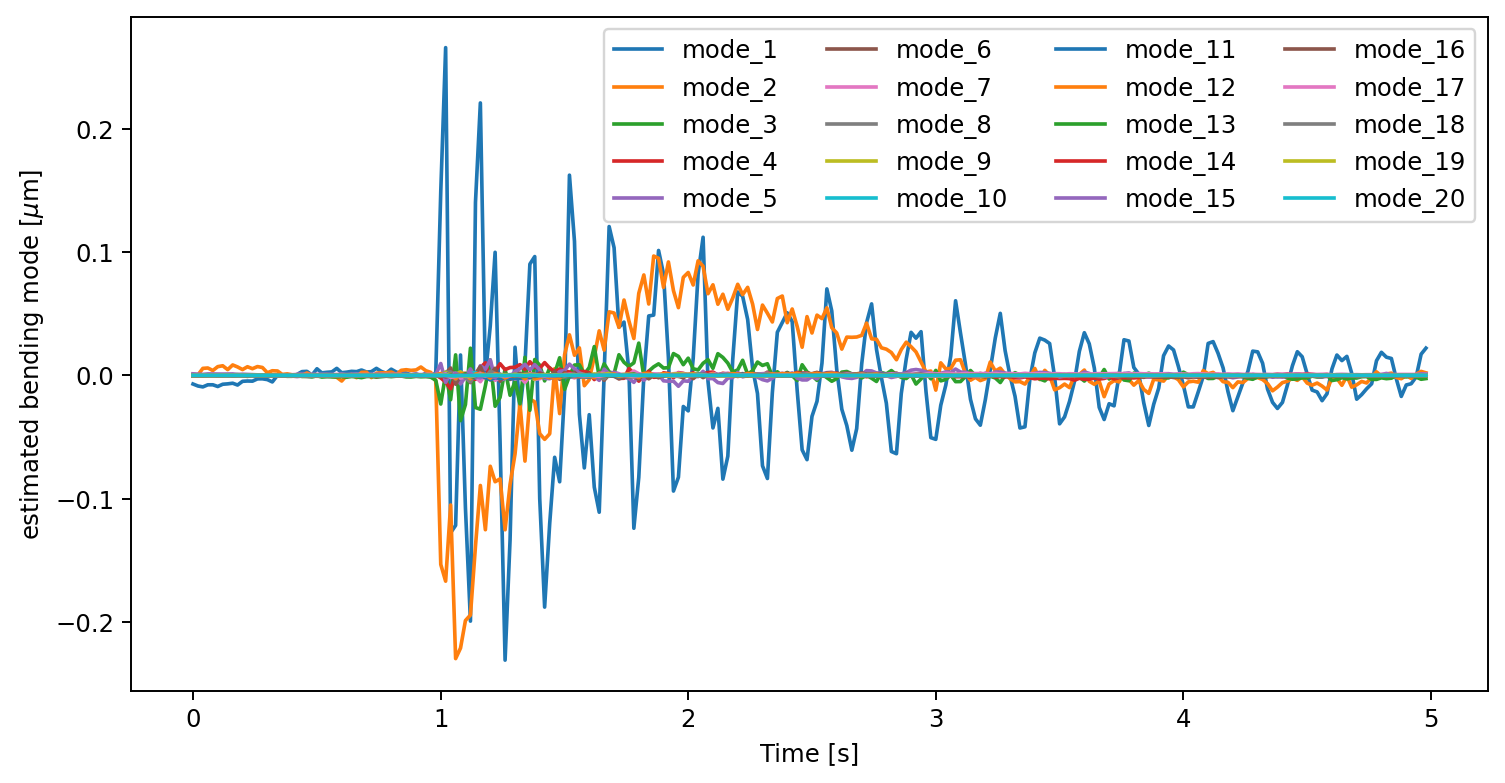

In [125]:
plt.figure(dpi=175, figsize=(10,5))
for i, mode in enumerate(col_names):
    plt.plot(time, mode_frame[mode].values, label=mode_names[i])
plt.legend(ncol=4)
plt.xlabel("Time [s]")
plt.ylabel("estimated bending mode [$\mu$m]")

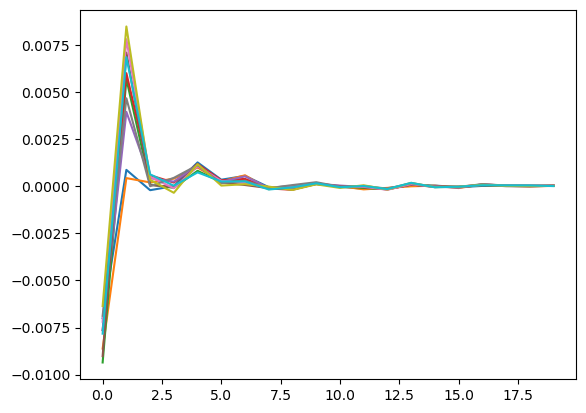

In [38]:
for i in np.arange(10):
    force0=test_dat.iloc[i,:].values
    plt.plot(np.arange(20), bmc.bending_mode(force0), )

#plt.hist()

In [ ]:
test_d

In [7]:
bmc.bending_mode

Signature: bmc.bending_mode(force)
Docstring:
Compute the bending mode.

Parameters
----------
force : `numpy.ndarray`
    Actuator forces in N.

Returns
-------
`numpy.ndarray`
    Estimated bending mode in um.
File:      ~/u/repos/sitcom/ts_ofc/python/lsst/ts/ofc/bend_mode_to_force.py
Type:      method


In [79]:
events["group"][58]

2

In [89]:
from lsst.sitcom import vandv


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [97]:
test_dat.iloc[0]

primaryCylinderFollowingError0     -0.184223
primaryCylinderFollowingError1     -0.293457
primaryCylinderFollowingError2     -0.267822
primaryCylinderFollowingError3     -1.026489
primaryCylinderFollowingError4      0.003296
                                      ...   
primaryCylinderFollowingError151   -0.407257
primaryCylinderFollowingError152   -1.184753
primaryCylinderFollowingError153   -0.796906
primaryCylinderFollowingError154   -0.144714
primaryCylinderFollowingError155   -0.192062
Name: 2023-05-30 10:46:09.129519+00:00, Length: 156, dtype: float64

/home/p/pferguso/u/repos/sitcom/notebooks_vandv/python/lsst/sitcom/vandv/m1m3.py:527: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fat = np.array(M1M3FATable.FATABLE)


<AxesSubplot: >

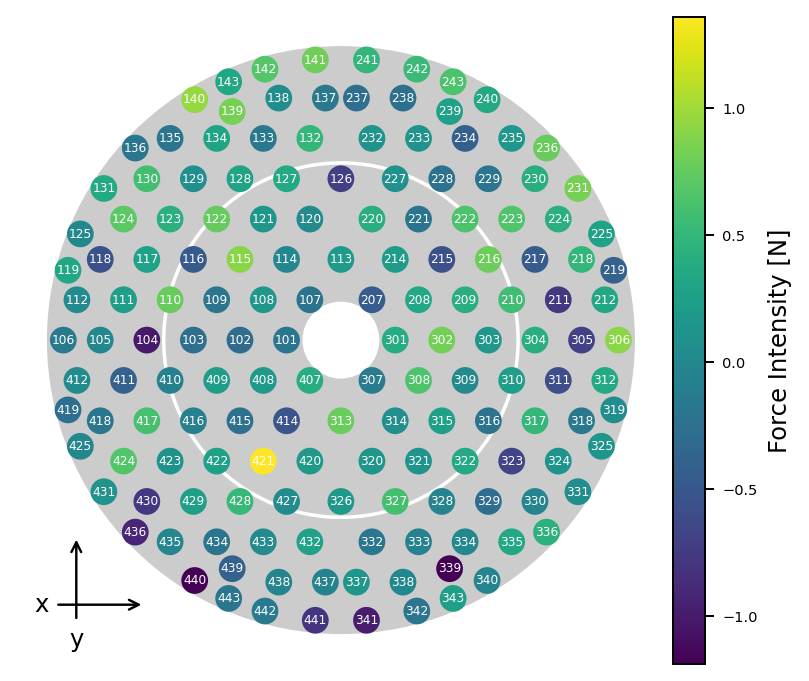

In [98]:
fig,ax=plt.subplots(dpi=175)
vandv.m1m3.snapshot_zforces_overview(ax, test_dat.iloc[0], prefix="primaryCylinderFollowingError")

In [93]:
test_dat[0]

KeyError: 0